# Import Required Libraries

In [2]:
# import libraries
import itertools
import asyncio
import numpy as np, matplotlib.pyplot as plt
import numpy
from numpy import *
from numpy.fft import *
from matplotlib.pyplot import *
from rtlsdr import RtlSdr
import pyModeS as pms
import gc
import pdb
import time
from sklearn.cluster import KMeans
from scipy.signal import convolve
%matplotlib inline
import random
import time

/home/james/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Receiver System Diagram

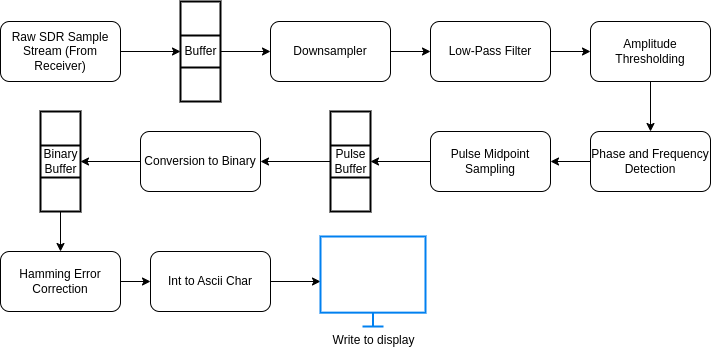

TODOS
- Profile and optimize code
- Make it work for real time
- Test it to see how far it can transmit

Filtering Theory Idea

The signal we are trying to recover is being broadcast at a frequency of 2 * BITS_PER_SEC. The sampling frequency is given by FS and the downsampling frequency by DOWNSAMPLE_FS. Obviously, the closer our DOWNSAMPLE_FS is to FS, the better our signal processing will be and the longer range it will have, since more samples means more data to work with to filter out the noise. But, we cannot make our DOWNSAMPLE_FS too large or it will become the bottleneck in the pipeline and we will have dropped samples due to the processing latency. The trick is to make DOWNSAMPLE_FS as high as possible to ensure the highest resolution possible for the system while ensuring that this processing does not cause a bottleneck and result in a buffer overflow / information loss.

The second factor to think about is our kernel design. We are broadcasting data at 2 * BITS_PER_SEC (currently 100 Hz). So we need to design our kernel (Gaussian kernel) to maximize the information gained at this frequency. To do this we will need to consider the kernel frequency response. Gaussian kernel has an exponentially decaying frequency response, making it a low-pass filter. But can we design a band-pass filter kernel with DoG (difference of Gaussian filter) specifically designed to only let 2 * BITS_PER_SEC signal through? Or some other kernel? It might be helpful to research how radio band-pass filters work. Then again, we might not even need a band-pass filter since our transmit frequency (100 Hz) is so low.

With these two optimization techniques in mind, we would potentially be able to parameterize our kernel size and DOWNSAMPLE_FS to maximize the performance envelope of our system. The tradeoff is this: do we want to maximize bit transmission rate for a given effective range? Or do we want to maximize range for a given transmission rate? Visualizing the two together, we get a "performance envelope graph" or sorts WRT bit rate vs effective range of our system.

Relevant resources:

**Filtering**
search terms: 
    * gaussian distribution full width at half maximum signal processing, 
    * optimal kernel sigma size for square wave
    * optimal kernel sigma size for square wave
- https://pysdr.org/content/filters.html Filters
- https://en.wikipedia.org/wiki/Filter_(signal_processing) Wikipedia what is a filter
- https://en.wikipedia.org/wiki/Gaussian_filter Gaussian Filter frequency response
- https://en.wikipedia.org/wiki/Difference_of_Gaussians Difference of Gaussians
- https://www.analog.com/media/en/training-seminars/design-handbooks/Software-Defined-Radio-for-Engineers-2018/SDR4Engineers_CH02.pdf Software-Defined Radio, ESPECIALLY chapter 2
- https://arxiv.org/pdf/2211.07123.pdf Filtering lecture notes

**System Performance / Throughput Optimization**
search terms:
    * signal processing system throughput optimization
- https://www.analog.com/en/analog-dialogue/articles/dsp-101-part-1.html DSP performance tradeoff
- https://schaumont.dyn.wpi.edu/ece4703b21/lecture8.html DSP performance optimization
- https://www.researchgate.net/figure/Physical-throughput-versus-calculated-range-for-80211n-reference-receiver-SISO_fig2_241183210 Throughput vs range graph

# Define Constants

In [37]:
# The receiver's sampling rate in GHz
FS = 2048000 # 2.048 GHz
# The frequency (in Hz) that we would like to downsample to
DOWNSAMPLE_FS = 100 * 2048
# The time it takes to transmit one bit according to our protocol, in milliseconds
TIME_ONE_BIT_MS = 20
# The bitrate per second
BITS_PER_SEC = 1000 / TIME_ONE_BIT_MS
# The expected number of samples it would take to represent one 
# DOWNSAMPLED pulse,where two pulses make up a bit
PULSE_NUM_SAMPLES = DOWNSAMPLE_FS * TIME_ONE_BIT_MS // 1000 // 2
# The expected number of samples it would take to represent one 
# RAW pulse, where two pulses make up a bit
PULSE_RAW_NUM_SAMPLES = FS * TIME_ONE_BIT_MS // 1000 // 2
# The sigma we use for our low-pass filter
SIGMA = PULSE_NUM_SAMPLES // 3 # Optimal sigma according to sampling theory??
# The payload of the packet in bits
PACKET_LENGTH_BITS = 16
# The length of the packet in pulses, it takes two pulses to represent a bit
PACKET_LENGTH_SAMPLES = PACKET_LENGTH_BITS * 2 * PULSE_NUM_SAMPLES
# The threshold at which template matching detects a preamble
PREAMBLE_THRESHOLD = 0.92
# The preamble sequence used to identify the header
preamble = [1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
PACKET_LENGTH_PULSES = 32
PREAMBLE_SEQUENCE = []
for element in preamble:
    for _ in range(PULSE_NUM_SAMPLES):
        PREAMBLE_SEQUENCE.append(element)
# The length of the preamble sequence
PREAMBLE_LENGTH_SAMPLES= len(PREAMBLE_SEQUENCE)

# Initialize Receiver

In [38]:
sdr = RtlSdr()
sdr.set_sample_rate(FS)    # sampling rate
sdr.set_center_freq(434.03e6)   # 1090MhZ center frequency
sdr.set_gain(0) 
N_Samples = 2048000 # approx 1 sec

LibUSBError: <LIBUSB_ERROR_IO (-1): Input/output error> "Could not open SDR (device index = 0)"

# Utility Functions

In [39]:
def read_and_return_data(buffer):
    """
    Buffer: the buffer to hold the raw I/Q samples from the software-defined radio.
    
    Returns: the sampled data for one second
    """
    y = abs(sdr.read_samples(N_Samples))   # get samples
    y = downsample(y, fs, 200)
    data = convert_to_binary(y)
    buffer.extend(data)
    return buffer

In [40]:
def plot_data(data, red_dot_indices=None):
    """
    Utility function to produce a pretty plot of sampled data.
    """
    width, height = figaspect(0.2)
    fig = figure(figsize=(width ,height ))
    p = plot( (data))
    title('magnitude of received signal')
    xlabel('samples')
    if red_dot_indices:
        for ind in red_dot_indices:
            plot([ind], [data[ind]], 'ro', markersize=10)
    show()

# Functions for Downsampling, Filtering, Amplitude Detection, Phase and Frequency Detection, Preamble Detection and Pulse Midpoint Sampling

In [41]:
def downsample(sample, orig_freq, new_freq):
    """
    Downsamples the samples in `sample` from `orig_freq` to `new_freq`.
    """
    assert 0 < new_freq < orig_freq, "New freq must be less than original frequency and greater than zero"
    assert orig_freq / new_freq == orig_freq // new_freq, "Original frequency must be a multiple of the new frequency"
    return sample[::orig_freq // new_freq]

In [42]:
def smoothing_filter(samples):
    """
    Applies a smoothing low-pass filter on the samples to reduce high-frequency jitter in the signal and 
    allow for more accurate threshold detection.
    """
    kernel_size = int(3 * SIGMA) + 1
    kernel = np.exp(-(np.arange(kernel_size) - kernel_size // 2)**2 / (2 * SIGMA**2))
    kernel /= np.sum(kernel)
    smoothed_samples = convolve(samples, kernel, mode='same')
    return smoothed_samples

In [43]:
kmeans = KMeans(n_clusters=2)
def find_amplitude_cutoff(samples):
    """
    Performs bimodal clustering on the samples to find high and low cutoff values for ASK (Amplitude Shift Keying)
    Returns the cluster centers, which can then be used to find a cutoff value.
    """
    kmeans.fit(samples.reshape(-1, 1))
    centers = kmeans.cluster_centers_
    val1 = centers[0][0]
    val2 = centers[1][0]
    return min([val1, val2]), max([val1, val2])

In [44]:
def digitize_samples(samples, threshold):
    """
    Digitizes samples, converting their raw values into pulse values (0 and 1) according to the cutoff threshold.
    """
    return [int(sample > threshold) for sample in samples]

In [45]:
@deprecated
def find_pulse_frequency_and_phase(samples):
    """
    Finds the period (inverse of frequency) and phase midpoint of the signal. It does this by accepting a 
    binary digital signal, samples, and calculating the fundamental pulse duration. It then uses this to 
    find the midpoint of the peaks in the signal, passing the phase and period information which will be used
    to sample the signal accordingly.
    """
#     period = PULSE_NUM_SAMPLES

#     # Find the index of the peak.
#     phase = np.argmax(samples) % period
    
#     return phase, period
    change_indices = []
    for i in range(len(samples) - 1):
        if samples[i] != samples[i+1]:
            change_indices.append(i)
    
    # Compute period
    # differences = diff(change_indices)
    # filtered_values = filter(lambda x: x >= 0.95 * PULSE_NUM_SAMPLES and x <= 1.05 * PULSE_NUM_SAMPLES, differences)
    # period = int(mean(list(filtered_values)))
    period = PULSE_NUM_SAMPLES
    # TODO better / adaptive phase finding?
    phase = (int(mean([ind % period for ind in change_indices])) + period // 2) % period
    # hase = (change_indices[0] + change_indices[1])//2 % period
    return phase, period

NameError: name 'deprecated' is not defined

In [46]:
def correlation(template, candidate):
    """
    Uses template matching to compute a correlation score between the signal (buffer) and template (preamble)
    A higher score indicates a more likely match with the preamble. This is used for preamble and packet
    detection.
    """
    assert len(template) == len(candidate)
    correlation = np.dot(template, candidate)
    return correlation / np.linalg.norm(template) / np.linalg.norm(candidate)
# EXTREMELY SLOW!
#     correlation = 0
#     for j in range(len(template)):
#         if template[j] == candidate[j]:
#             correlation += 1
#     return correlation / len(template)

In [47]:
def extract_data(sample, phase, period):
    """
    Extracts data from the sampled data `sample` in accordance with the given phase and period info.
    """
    return sample[phase::period]

In [48]:
def detect_data_from_preamble(buffer, i):
    """
    Scans the buffer for preambles and data packets and adds the detected packet preamble starts to
    a list. Returns the new index where the scan should restart at.
    """
    detected_indices = []
    while i <= len(buffer) - (PREAMBLE_LENGTH_SAMPLES + PACKET_LENGTH_SAMPLES):
        # Compute the score
        score = correlation(PREAMBLE_SEQUENCE, buffer[i:i + PREAMBLE_LENGTH_SAMPLES])
        if score >= PREAMBLE_THRESHOLD:
            detected_indices.append(i)
            i = i + PREAMBLE_LENGTH_SAMPLES + PACKET_LENGTH_SAMPLES
        else:
            i += 1
        
    return detected_indices, i

# Functions for Converting Data Pulse to Binary, Hamming Decoding, Converting to Char

In [49]:
def extract_bit(byte, pos):
    """
    Extracts and returns a single bit in byte according to position (from right) pos.
    """
    return (byte >> pos) & 0x01


def hamming_encode_nibble(data):
    """
    Encodes the nibble (4 bits) as a byte (8 bits) using the Hamming(8, 4) encoding.
    """
    # Get data bits
    d = [0, 0, 0, 0]
    d[0] = extract_bit(data, 0)
    d[1] = extract_bit(data, 1)
    d[2] = extract_bit(data, 2)
    d[3] = extract_bit(data, 3)

    # Calculate hamming bits
    h = [0, 0, 0]
    h[0] = (d[1] + d[2] + d[3]) % 2
    h[1] = (d[0] + d[2] + d[3]) % 2
    h[2] = (d[0] + d[1] + d[3]) % 2
    
    # Calculate parity bit, using even parity
    p = 0 ^ d[0] ^ d[1] ^ d[2] ^ d[3] ^ h[0] ^ h[1] ^ h[2]

    # Encode byte
    encoded = (data & 0x0f)
    encoded |= (p << 7) | (h[2] << 6) | (h[1] << 5) | (h[0] << 4)

    return encoded

In [50]:
SYNDROME_CHECK = [-1, 6, 5, 0, 4, 1, 2, 3]
# P H2 H1 H0 D3 D2 D1 D0
def hamming_decode_byte(byte):
    """
    Decodes the Hamming(8, 4) code, returning the attempted decoded nibble, and boolean flags indicating 
    1) whether there was an error 
    2) whether that error was corrected or not
    """
    error, corrected = 0, 0
    s = [(extract_bit(byte, 1) + extract_bit(byte, 2) + extract_bit(byte, 3) + extract_bit(byte, 4)) % 2,
        (extract_bit(byte, 0) + extract_bit(byte, 2) + extract_bit(byte, 3) + extract_bit(byte, 5)) % 2,
        (extract_bit(byte, 0) + extract_bit(byte, 1) + extract_bit(byte, 3) + extract_bit(byte, 6)) % 2]
    syndrome = (s[0] << 2) | (s[1] << 1) | s[2]
    if syndrome:
        error += 1
        byte ^= (1 << SYNDROME_CHECK[syndrome])
        corrected += 1
    p = 0
    for i in range(0, 7):
        p ^= extract_bit(byte, i)
    if p != extract_bit(byte, 7):
        if syndrome:
            corrected -= 1
        else:
            error += 1
            corrected += 1
    return ((byte & 0x0f), error, corrected)

In [51]:
def decode(pulse_samples):
    """
    Given a pulse samples corresponding to a packet, attempts to decode the pulse into the corresponding letter.
    It does this by
    0) Downsampling 
    1) Converting the pulse pattern into actual 0's and 1's. A pulse of [0, 1] corresponds to 0 and 
       a pulse pattern of [1, 0] corresponds to a 1.
    2) Decodes the bit pattern of 0's and 1's using the Hamming(8, 4) protocol
    3) Reassembles the decoded char value
    4) Converts the reassembled char value back to a char
    """
    result = []
    pulse_pattern = extract_data(pulse_samples, PULSE_NUM_SAMPLES // 2, PULSE_NUM_SAMPLES)
    assert len(pulse_pattern) == PACKET_LENGTH_PULSES
    for i in range(0, PACKET_LENGTH_PULSES, 2):
        if pulse_pattern[i] == 1 and pulse_pattern[i+1] == 0:
            result.append(1)
        elif pulse_pattern[i+1] == 1 and pulse_pattern[i] == 0:
            result.append(0)
        else:
            result.append(0)
    first_byte = bits_to_int(result[:8])
    second_byte = bits_to_int(result[8:])
    first_byte_decoded, error, corrected = hamming_decode_byte(first_byte)
    second_byte_decoded, error, corrected = hamming_decode_byte(second_byte)
    ascii_index = (first_byte_decoded << 4) | second_byte_decoded
    return convert_to_char(ascii_index)

def bits_to_int(bit_seq):
    """
    Accepts a list of bits, LSB first, and converts it to its actual value.
    """
    assert len(bit_seq) == 8
    res = 0
    for i in range(8):
        res += 2**(i) * bit_seq[i]
    return res
    

def convert_to_char(ascii_index):
    """
    Converts int index to ASCII char value.
    """
    return chr(ascii_index)

In [52]:
def extract_chars_from_data(buffer, i):
    """
    Scans the buffer starting at index i and attempts to detect and decode encoded character data. The
    buffer is a pulse buffer corresponding to 0 and 1 pulses. Returns the decoded characters along with
    an index telling the algorith where to start scanning the next time.
    """
    res = []
    detected, new_i = detect_data_from_preamble(buffer, i)
    for item in detected:
        char = decode(buffer[item+PREAMBLE_LENGTH_SAMPLES:item+PREAMBLE_LENGTH_SAMPLES+PACKET_LENGTH_SAMPLES])
        res.append(char)
    return res, new_i

<!-- # Steps
# 1) Apply a smoothing filter on the data to remove noise and jitter
# 2) Use k-means clustering to find high and low values in the data
# 3) do clock recovery
#   a) Take the fourier transform
#   b) Look in the 90 to 110 Hzer  range to find the pulse frequency
# 4) Use that to sample our signal at the the right sampling rate and recover the data -->

# TESTING SECTION:

Generate a synthetic signal for msg according to our amplitude shift keying (ASK) protocol with high value low value, and signal Gaussian noise sigma.

In [53]:
def add_one(signal_buffer, high_val, low_val, sigma):
    ones = np.random.normal(high_val, sigma, size=PULSE_RAW_NUM_SAMPLES).tolist()
    zeros = np.random.normal(low_val, sigma, size=PULSE_RAW_NUM_SAMPLES).tolist()
    signal_buffer.extend(ones)
    signal_buffer.extend(zeros)
            
def add_zero(signal_buffer, high_val, low_val, sigma):
    ones = np.random.normal(high_val, sigma, size=PULSE_RAW_NUM_SAMPLES).tolist()
    zeros = np.random.normal(low_val, sigma, size=PULSE_RAW_NUM_SAMPLES).tolist()
    signal_buffer.extend(zeros)
    signal_buffer.extend(ones)

def add_nothing(signal_buffer, low_val, sigma):    
    zeros = np.random.normal(low_val, sigma, size=2*PULSE_RAW_NUM_SAMPLES).tolist()
    signal_buffer.extend(zeros)
    
def add_ads_header(signal_buffer, high_val, low_val, sigma):
    add_one(signal_buffer, high_val, low_val, sigma)
    add_one(signal_buffer, high_val, low_val, sigma)
    add_nothing(signal_buffer, low_val, sigma)
    add_zero(signal_buffer, high_val, low_val, sigma)
    add_zero(signal_buffer, high_val, low_val, sigma)
    add_nothing(signal_buffer, low_val, sigma)
    add_nothing(signal_buffer, low_val, sigma)
    add_nothing(signal_buffer, low_val, sigma)
    
def add_transmission(byte, signal_buffer, high_val, low_val, sigma):
    for i in range(0, 8):
        bit = extract_bit(byte, i)
        if bit == 1:
            add_one(signal_buffer, high_val, low_val, sigma)
        else:
            add_zero(signal_buffer, high_val, low_val, sigma) 

def generate_synthetic_signal(msg, high_val, low_val, sigma, random_noise_head = 0):
    signal_buffer = [low_val + (high_val - low_val) * random.random() for _ in range(random_noise_head)]
    # For each character in msg:
    for c in msg:
        byte = ord(c)
        # get lower bits hamming representation
        lower_bits = 0xf & byte
        hamming_lower = hamming_encode_nibble(lower_bits)
        
        # get upper bits hamming representation
        upper_bits = (0xf0 & byte) >> 4
        hamming_upper = hamming_encode_nibble(upper_bits)
        
        # add ads header
        add_ads_header(signal_buffer, high_val, low_val, sigma)
        
        # add upper bits transmission
        add_transmission(hamming_upper, signal_buffer, high_val, low_val, sigma)
        
        # add lower bits transmission
        add_transmission(hamming_lower, signal_buffer, high_val, low_val, sigma)
    return signal_buffer

Visualize the generated signal for " " (space)

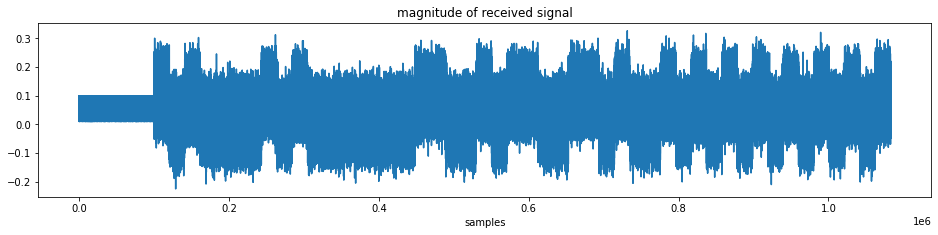

In [19]:
plot_data(generate_synthetic_signal(" ", 0.1, 0.01, 0.05, random_noise_head=100000))

Test if the software can read and decrypt a single letter " " from end to end.

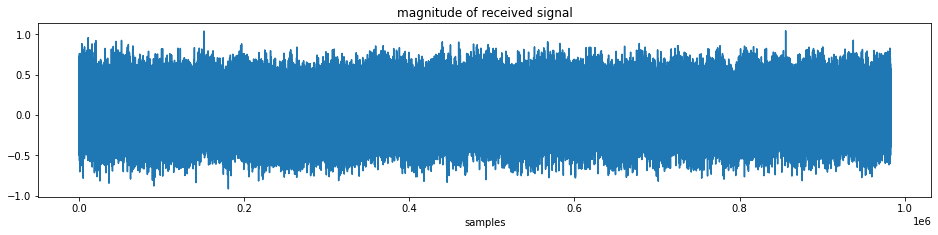

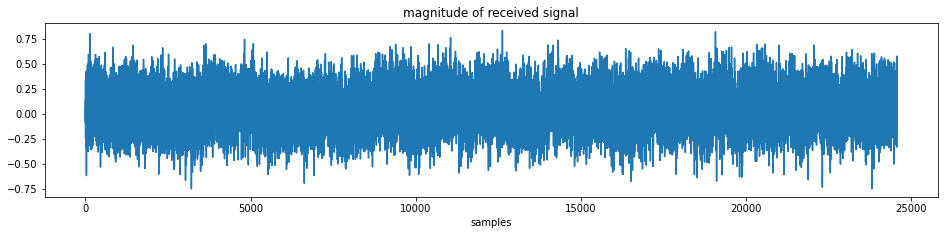

low is 0.019378235284833133 and high is 0.08581263881434781


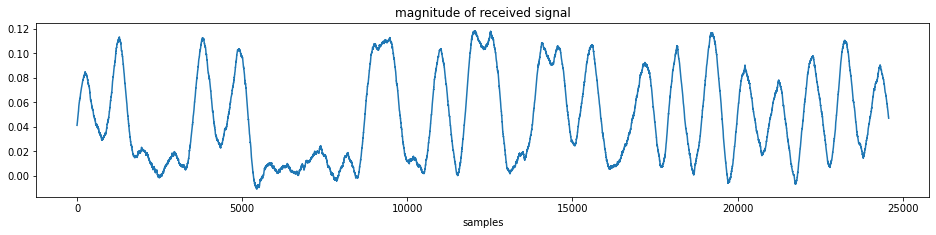

256
512


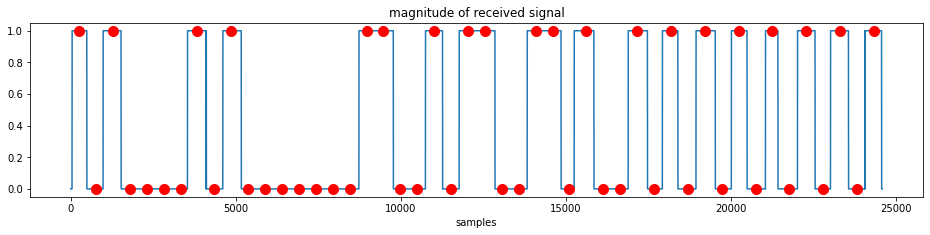

[' ']
24576
Execution time: 0.9754559993743896


In [37]:
def test_synthetic_complete_decode_single_character_space():
    data = generate_synthetic_signal(" ", 0.1, 0.01, 0.2) # EXTREMELY NOISY SIGNAL
    plot_data(data)
    data = downsample(data, FS, DOWNSAMPLE_FS)
    plot_data(data)
    # Create the Gaussian kernel.
    smoothed_data = smoothing_filter(data)
    low, high = find_amplitude_cutoff(smoothed_data)
    print(f"low is {low} and high is {high}")
    data = digitize_samples(smoothed_data, (low + high) / 2)
    plot_data(smoothed_data)
    phase, period = PULSE_NUM_SAMPLES // 2, PULSE_NUM_SAMPLES
    print(phase)
    print(period)
    plot_data(data, [phase + k * period for k in range(48)])
    chars, i = extract_chars_from_data(data, 0)
    print(chars)
    print(i)
    assert chars == [' ']

start_time = time.time()
test_synthetic_complete_decode_single_character_space()
end_time = time.time()

print("Execution time:", end_time - start_time)

Visualize the generated signal for "ant"

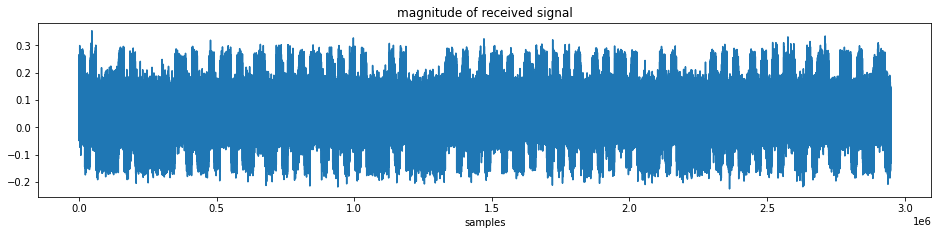

In [38]:
plot_data(generate_synthetic_signal("ant", 0.1, 0.01, 0.05))

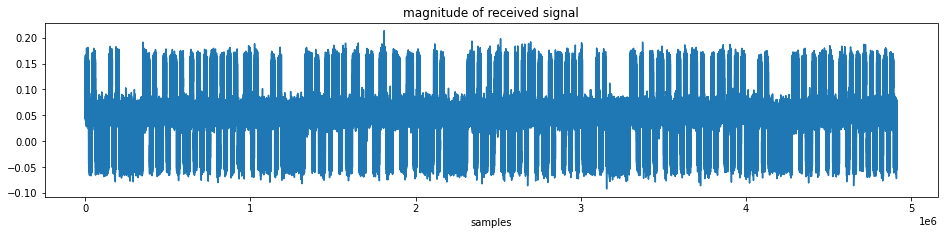

low is 0.019419431603730407 and high is 0.08432338492447003


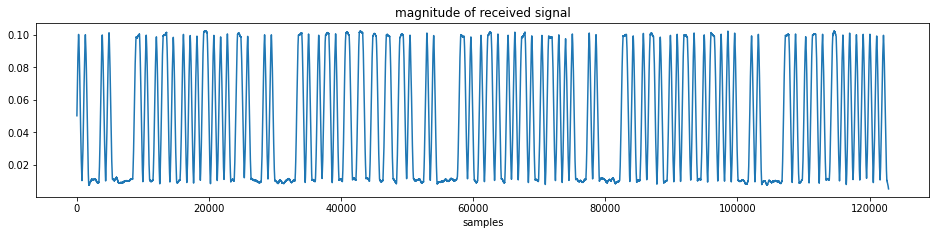

256
512


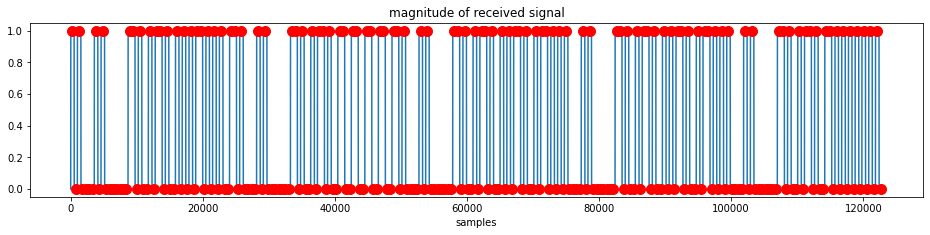

['h', 'e', 'l', 'l', 'o']
122880
Execution time: 1.7998554706573486


In [40]:
def test_synthetic_complete_decode_multiple_character():
    word = 'hello'
    data = generate_synthetic_signal(word, 0.1, 0.01, 0.02) # EXTREMELY NOISY SIGNAL
    plot_data(data)
    data = downsample(data, FS, DOWNSAMPLE_FS)
    # Create the Gaussian kernel.
    smoothed_data = smoothing_filter(data)
    low, high = find_amplitude_cutoff(smoothed_data)
    print(f"low is {low} and high is {high}")
    data = digitize_samples(smoothed_data, (low + high) / 2)
    plot_data(smoothed_data)
    phase, period = PULSE_NUM_SAMPLES // 2, PULSE_NUM_SAMPLES
    print(phase)
    print(period)
    plot_data(data, [phase + k * period for k in range(len(word) * 48)])
    chars, i = extract_chars_from_data(data, 0)
    print(chars)
    print(i)
    assert chars == list(word)

start_time = time.time()
test_synthetic_complete_decode_multiple_character()
end_time = time.time()

print("Execution time:", end_time - start_time)

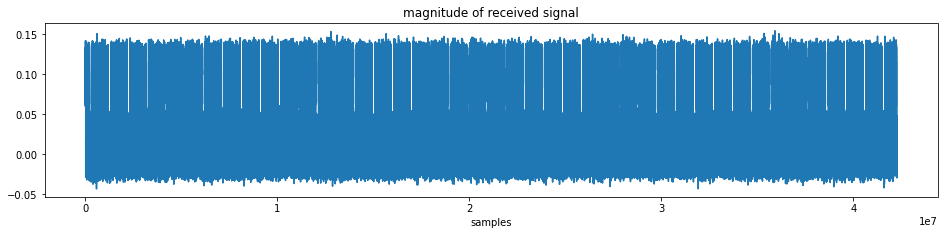

low is 0.019442860975342778 and high is 0.08403647896881085


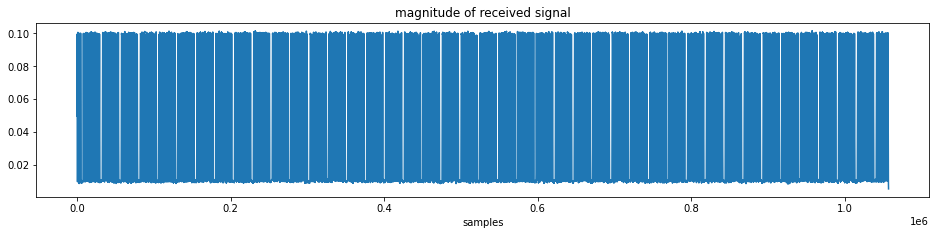

256
512


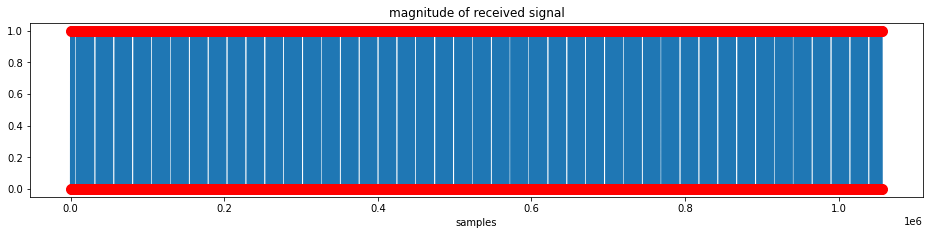

['t', 'h', 'e', ' ', 'q', 'u', 'i', 'c', 'k', ' ', 'b', 'r', 'o', 'w', 'n', ' ', 'f', 'o', 'x', ' ', 'j', 'u', 'm', 'p', 's', ' ', 'o', 'v', 'e', 'r', ' ', 't', 'h', 'e', ' ', 'l', 'a', 'z', 'y', ' ', 'd', 'o', 'g']
1056768
Execution time: 13.917631149291992


In [41]:
def test_synthetic_complete_decode_sentence():
    sentence = 'the quick brown fox jumps over the lazy dog'
    data = generate_synthetic_signal(sentence, 0.1, 0.01, 0.01) # VERY NOISY SIGNAL
    plot_data(data)
    data = downsample(data, FS, DOWNSAMPLE_FS)
    # Create the Gaussian kernel.
    smoothed_data = smoothing_filter(data)
    low, high = find_amplitude_cutoff(smoothed_data)
    print(f"low is {low} and high is {high}")
    data = digitize_samples(smoothed_data, (low + high) / 2)
    plot_data(smoothed_data)
    phase, period = PULSE_NUM_SAMPLES // 2, PULSE_NUM_SAMPLES
    print(phase)
    print(period)
    plot_data(data, [phase + k * period for k in range(len(sentence) * 48)])
    chars, i = extract_chars_from_data(data, 0)
    print(chars)
    print(i)
    assert chars == list(sentence)

start_time = time.time()
test_synthetic_complete_decode_sentence()
end_time = time.time()

print("Execution time:", end_time - start_time)

Test if the Hamming decoding code can detect and correct all one-bit errors.

In [101]:
def test_hamming_encode_decode():
    def bit_flip(byte, pos):
        return byte ^ (0b1 << pos)
    for i in range(0b0000, 0b1111 + 1):
        h = hamming_encode_nibble(i)
        for j in range(0, 8):
            h_err = bit_flip(h, j)
            i_decoded, error, corrected = hamming_decode_byte(h_err)
            assert i_decoded == i
            print(f"PASS, error: {error} corrected: {corrected} orig: {bin(i)} enc: {bin(h)} enc err: {bin(h_err)} decoded: {bin(i_decoded)}")

test_hamming_encode_decode()

PASS, error: 1 corrected: 1 orig: 0b0 enc: 0b0 enc err: 0b1 decoded: 0b0
PASS, error: 1 corrected: 1 orig: 0b0 enc: 0b0 enc err: 0b10 decoded: 0b0
PASS, error: 1 corrected: 1 orig: 0b0 enc: 0b0 enc err: 0b100 decoded: 0b0
PASS, error: 1 corrected: 1 orig: 0b0 enc: 0b0 enc err: 0b1000 decoded: 0b0
PASS, error: 1 corrected: 1 orig: 0b0 enc: 0b0 enc err: 0b10000 decoded: 0b0
PASS, error: 1 corrected: 1 orig: 0b0 enc: 0b0 enc err: 0b100000 decoded: 0b0
PASS, error: 1 corrected: 1 orig: 0b0 enc: 0b0 enc err: 0b1000000 decoded: 0b0
PASS, error: 1 corrected: 1 orig: 0b0 enc: 0b0 enc err: 0b10000000 decoded: 0b0
PASS, error: 1 corrected: 1 orig: 0b1 enc: 0b11100001 enc err: 0b11100000 decoded: 0b1
PASS, error: 1 corrected: 1 orig: 0b1 enc: 0b11100001 enc err: 0b11100011 decoded: 0b1
PASS, error: 1 corrected: 1 orig: 0b1 enc: 0b11100001 enc err: 0b11100101 decoded: 0b1
PASS, error: 1 corrected: 1 orig: 0b1 enc: 0b11100001 enc err: 0b11101001 decoded: 0b1
PASS, error: 1 corrected: 1 orig: 0b1 en

Test if the SDR can completely read, process, and decode a one-second signal from end to end.

low is 0.005742278394137737 and high is 0.013610284931335492
0
20
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 

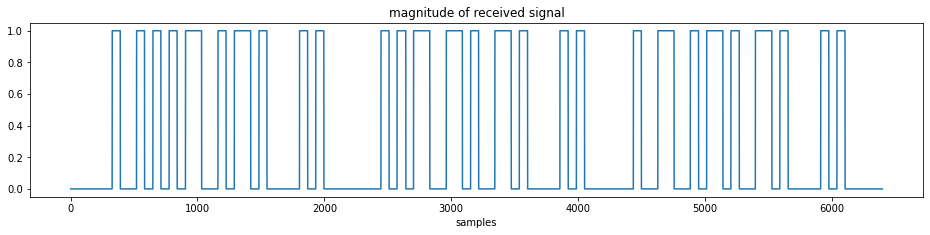

In [18]:
def test_sdr_complete_decode():
    data = abs(sdr.read_samples(N_Samples))
    data = downsample(data, fs, 100 * 64)
    # Create the Gaussian kernel.
    data = smoothing_filter(data)
    low, high = find_amplitude_cutoff(data)
    print(f"low is {low} and high is {high}")
    data = convert_to_binary(data, (low + high) / 2)
    plot_data(data)
    phase, period = find_pulse_frequency_and_phase(data, low, high)
    print(phase)
    print(period)
    data = extract_data(data, phase, period)
    print(data)
    chars, i = extract_chars_from_data(data, 0)
    print(chars)
    print(i)
test_sdr_complete_decode()

Test to check actual buffer read rate and time gaps for SDR to verify that there are no time gaps

In [23]:
def test_check_buffer_read_rate_gaps():
    buffer = []
    i = 0
    start = time.time()
    while True:
        # pdb.set_trace()
    #     buffer = read_and_return_data(buffer)
        #     current = time.time()
        y = abs(sdr.read_samples(N_Samples))   # get samples
        y = downsample(y, fs, 100)
        current = time.time()
        print(f"{current - start} elapsed time")
        print(f"Read {len(y)}")
        start = current
        # buffer.append(y)

    #     chars, new_i = extract_chars_from_data(buffer, i)
    #     print("".join(chars), end="")
    #     i = new_i
test_check_buffer_read_rate_gaps()

1.0705766677856445 elapsed time
Read 100
1.064272403717041 elapsed time
Read 100
1.0568535327911377 elapsed time
Read 100
1.0603609085083008 elapsed time
Read 100
1.0607225894927979 elapsed time
Read 100
1.0617270469665527 elapsed time
Read 100
1.0597028732299805 elapsed time
Read 100
1.0452234745025635 elapsed time
Read 100
1.06632399559021 elapsed time
Read 100


KeyboardInterrupt: 

In [54]:
def cirslice(l, a, b):
    if b >= a:
        return l[a:b]
    else:
        return l[a:] + l[:b]

In [55]:
class MockSDR:
    def __init__(self, msg, high, low, sigma):
        self.message =  generate_synthetic_signal(msg, high, low, sigma)
        self.sections_per_second = 6
        self.samples_per_chunk = FS // self.sections_per_second
        
    async def stream(self):
        max_i = len(self.message) // self.samples_per_chunk
        i = 0
        while True:
            start_ind = (i * self.samples_per_chunk) % len(self.message)
            end_ind = ((i + 1) * self.samples_per_chunk) % len(self.message)
            yield cirslice(self.message, start_ind, end_ind)
            i += 1
            await asyncio.sleep(1 / self.sections_per_second)

In [63]:
mockSDR = MockSDR("hello world!", 0.1, 0.01, 0.15)

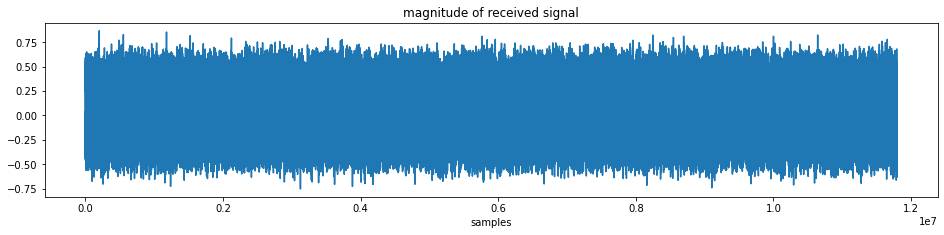

In [64]:
plot_data(mockSDR.message)

In [65]:
async def mock_streaming(buffer_1s, downsampled_buffer, start_time):
    i = 0
    async for samples in mockSDR.stream():
        buffer_1s.extend(samples)
        if len(buffer_1s) >= FS:
            start = time.time()
            raw_downsamples = downsample(buffer_1s[:FS], FS, DOWNSAMPLE_FS)
            buffer_1s = buffer_1s[FS:]
            
            # Window and process data
            data = smoothing_filter(raw_downsamples)
            low, high = find_amplitude_cutoff(data)
            cutoff_threshold = (low + high) / 2
            data = digitize_samples(data, cutoff_threshold)
            downsampled_buffer.extend(data)
            chars, i = extract_chars_from_data(downsampled_buffer, i)
            downsampled_buffer = downsampled_buffer[i:]
            i = 0
            print("".join(chars))
            print(f"{time.time() - start} elapsed time")
        current = time.time()
        
            
#         print(buffer_1s[:100])
#         print(raw_downsamples)
#         print(downsamples)
#         print(f"{current - start_time} elapsed time")
#         print(f"Read {len(samples)}, total downsampled buffer length {len(downsampled_buffer)}")
#         print(f"Average downsampled samples / sec {len(downsampled_buffer) / (current - start_time)}")

async def test_streaming_end_to_end_decode():
    buffer_1s = []
    downsampled_buffer = []
    start_time = time.time()
    await mock_streaming(buffer_1s, downsampled_buffer, start_time)
    
await test_streaming_end_to_end_decode()

he
0.5045723915100098 elapsed time
ll
0.2698526382446289 elapsed time
o 
0.26917171478271484 elapsed time
wo
0.2767598628997803 elapsed time
rl
0.25899410247802734 elapsed time
d!
0.2599167823791504 elapsed time
he
0.2786104679107666 elapsed time
ll
0.27855372428894043 elapsed time
o 
0.2808225154876709 elapsed time
wo
0.27938127517700195 elapsed time
rl
0.32972288131713867 elapsed time
d!h
0.29979872703552246 elapsed time
el
0.28540635108947754 elapsed time
lo
0.3480527400970459 elapsed time
 w
0.2887156009674072 elapsed time
or
0.2824995517730713 elapsed time
ld
0.27849435806274414 elapsed time


CancelledError: 

Test to stream data from the mock SDR and end-to-end decode it on the fly

In [28]:
async def mock_streaming(buffer_1s, downsampled_buffer, start_time):
    i = 0
    async for samples in mockSDR.stream():
        buffer_1s.extend(samples)
        if len(buffer_1s) >= FS:
            raw_downsamples = downsample(buffer_1s[:FS], FS, DOWNSAMPLE_FS)
            buffer_1s = buffer_1s[FS:]
            
            # Window and process data
            data = smoothing_filter(raw_downsamples)
            low, high = find_amplitude_cutoff(data)
            cutoff_threshold = (low + high) / 2
            data = digitize_samples(data, cutoff_threshold)
            downsampled_buffer.extend(data)
            chars, i = extract_chars_from_data(downsampled_buffer, i)
            print("".join(chars), end="")
        current = time.time()
        
            
#         print(buffer_1s[:100])
#         print(raw_downsamples)
#         print(downsamples)
#         print(f"{current - start_time} elapsed time")
#         print(f"Read {len(samples)}, total downsampled buffer length {len(downsampled_buffer)}")
#         print(f"Average downsampled samples / sec {len(downsampled_buffer) / (current - start_time)}")

async def test_streaming_end_to_end_decode():
    buffer_1s = []
    downsampled_buffer = []
    start_time = time.time()
    await mock_streaming(buffer_1s, downsampled_buffer, start_time)
    
await test_streaming_end_to_end_decode()

hello world!hello world!hello world!h

CancelledError: 

Test to stream data from SDR and end-to-end decode it on the fly 

In [236]:
async def streaming(buffer_1s, downsampled_buffer, start_time):
    i = 0
    pdb.set_trace()
    async for samples in sdr.stream():
        buffer_1s.extend(abs(samples))
        if len(buffer_1s) > fs:
            raw_downsamples = downsample(buffer_1s[:fs], fs, 100 * 64)
            buffer_1s = buffer_1s[fs:]
            
            # Window and process data
            data = smoothing_filter(raw_downsamples)
            low, high = find_amplitude_cutoff(data)
            cutoff_threshold = (low + high) / 2
            data = convert_to_binary(data, cutoff_threshold)
            phase, period = find_pulse_frequency_and_phase(data, low, high)
            data = extract_data(data, phase, period)
            downsampled_buffer.extend(data)
            # print(raw_downsamples)
            
            chars, new_i = extract_chars_from_data(downsampled_buffer, i)
            print("".join(chars), end="")
            i = new_i
        current = time.time()
            
#         print(buffer_1s[:100])
#         print(raw_downsamples)
#         print(downsamples)
#         print(f"{current - start_time} elapsed time")
#         print(f"Read {len(samples)}, total downsampled buffer length {len(downsampled_buffer)}")
#         print(f"Average downsampled samples / sec {len(downsampled_buffer) / (current - start_time)}")

def test_streaming_end_to_end_decode():
    buffer_1s = []
    downsampled_buffer = []
    start_time = time.time()
    await streaming(buffer_1s, downsampled_buffer, start_time)

# Data Visualizations

Text(0, 0.5, 'Value')

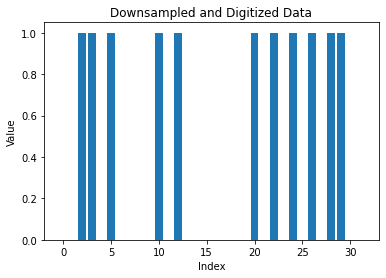

In [18]:
bar(range(32), buffer[:32])
title("Downsampled and Digitized Data")
xlabel("Time (us)")
ylabel("Value")

Text(0, 0.5, 'Value')

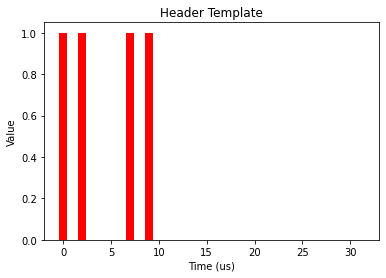

In [40]:
bar(range(32), template + 16 * [0], color="red")
title("Header Template")
xlabel("Time (us)")
ylabel("Value")

In [27]:
len(correlation(template, buffer[:32]))

17

# Plot Data From Experiments

In [2]:
transmission_only = [(0,200), (500, 198), (1000, 191), (1500, 161), (2000, 83), (2500, 19), (3000, 16), (3500, 3), (4000, 0)]
transmission_and_error_correction = [(0, 100), (500, 99), (1000, 99), (1500, 98), (2000, 96), (2500, 91), (3000, 80), (3500, 56), (4000, 25)]
transmission_and_error_correction_and_compression = [(0, 193), (500, 187), (1000, 186), (1500, 183), (2000, 170), (2500, 131), (3000, 102), (3500, 64), (4000, 27)]

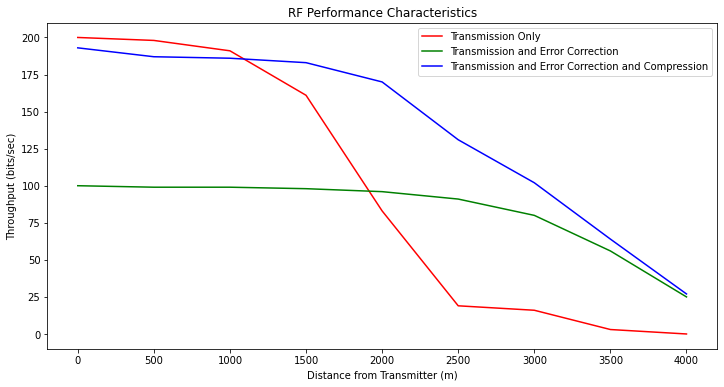

In [11]:
figure(figsize=(12, 6))
plot([x[0] for x in transmission_only], [x[1] for x in transmission_only], 'r-', label='Transmission Only')
plot([x[0] for x in transmission_and_error_correction], [x[1] for x in transmission_and_error_correction], 'g-', label='Transmission and Error Correction')
plot([x[0] for x in transmission_and_error_correction_and_compression], [x[1] for x in transmission_and_error_correction_and_compression], 'b-', label='Transmission and Error Correction and Compression')
xlabel('Distance from Transmitter (m)')
ylabel('Throughput (bits/sec)')
title("RF Performance Characteristics")
legend(loc='upper right')
show()